## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

1. Download and import Load the smoking dataset from: [https://data.princeton.edu/wws509/datasets/#smoking](https://data.princeton.edu/wws509/datasets/#smoking). Then perform a train-test split on the data;
2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables;
3. Evaluate the regression fit on test data using MAE and MSE error metrics.

In [1]:
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
from sklearn import datasets
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

In [123]:
# load data from csv and remove NA values
data = pd.read_table("data/smoking.raw", delim_whitespace=True, header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       36 non-null     int64
 1   1       36 non-null     int64
 2   2       36 non-null     int64
 3   3       36 non-null     int64
dtypes: int64(4)
memory usage: 1.2 KB


In [124]:
data.columns = ["age", "smoke", "pop", "dead"]

data.head(3)

,age,smoke,pop,dead
0,1,1,656,18
1,2,1,359,22
2,3,1,249,19


At first step I decided to normalize the columns `age` and `smoke` in order to have two columns that their range is from 0 to 1.
Then, I proceeded to consider the log of the `pop` column and use it as a predictor for our Generalized Linear Model. 
This choice is justified by the fact that the expected value of the deaths among a population is related by the risk factors by

$$ \mathbb{E} [\text{deaths}] = \exp({b + w_0\text{age} + w_1 \text{smoke} + w_2 \log (\text{pop}})) 
                              = \text{pop}^{w_2} \cdot e ^{b +w_0\text{age} + w_1 \text{smoke}}  $$

In [131]:
# normalization
data["age"] = data["age"]/data["age"].max()
data["smoke"] = data["smoke"]/data["smoke"].max()
# logarithm of pop
data["pop"]=np.log(data["pop"])
data=data.sample(frac=1) # shuffling dataset

data.head()

,age,smoke,pop,dead
27,0.111111,1.00,-0.300992,124
5,0.666667,0.25,-0.429785,170
25,0.888889,0.75,-0.433272,337
10,0.222222,0.50,-0.846391,4
21,0.444444,0.75,-0.276863,576


After this data-cleaning phase, I separated the train and test with the ratio 80:20.

In [132]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [133]:
x_test = torch.stack([torch.tensor(test_dataset.dataset[column].values[test_dataset.indices], dtype=torch.float64)
                           for column in ["age","smoke","pop"]], 1)
y_test = torch.tensor(test_dataset.dataset.dead.values[test_dataset.indices], dtype=torch.int64)

x_train = torch.stack([torch.tensor(train_dataset.dataset[column].values[train_dataset.indices], dtype=torch.float64)
                           for column in ["age","smoke","pop"]], 1)
y_train = torch.tensor(train_dataset.dataset.dead.values[train_dataset.indices], dtype=torch.float64)


print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([28, 3]) 
y_train.shape = torch.Size([28])

x_test.shape = torch.Size([8, 3]) 
y_test.shape = torch.Size([8])


In order to set the model and guide for our SVI object, I assume that 

\begin{align*}
w&\sim\mathcal{N}(0,1)\\
b&\sim\text{LogNormal}(0,1)\\
\hat{y}&= \exp(w x + b)\\
y &\sim \mathcal{P}(\hat{y}).
\end{align*}

Then we define the family of posterior distributions, by setting a Gamma distribution on $w$ and a Log-Normal on $b$, and run SVI inference on $(x,y)$ data.


In [134]:
pyro.clear_param_store()

def smoke_model(predictors, deaths):
    n_observations, n_predictors = predictors.shape

    # sample weights
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), 
                                                torch.ones(n_predictors)))

    b = pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))  
    
    yhat = torch.exp((w*predictors).sum(dim=1)+b)

    # condition on the observations
    with pyro.plate("deaths", len(deaths)):
        pyro.sample("obs", dist.Poisson(yhat), obs=deaths)

def smoke_guide(predictors, deaths=None):
    
    n_observations, n_predictors = predictors.shape
        
    w_loc = pyro.param("w_loc", dist.Uniform(0,1).to_event()([n_predictors]), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", dist.Uniform(0,1).to_event()([n_predictors]), constraint=constraints.positive)

    
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", dist.Uniform(0,1).to_event()([1]))
    b_scale = pyro.param("b_scale", dist.Uniform(0,1).to_event()([1]), constraint=constraints.positive)
    
    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))    
    
smoke_svi = SVI(model=smoke_model, guide=smoke_guide, 
              optim=optim.ClippedAdam({'lr' : 0.03}), 
              loss=Trace_ELBO()) 

losses = []
for step in range(2000):
    loss = smoke_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 438.6431917613916
Step 100 : loss = 168.0436792483582
Step 200 : loss = 84.82762190522628
Step 300 : loss = 66.51915530519645
Step 400 : loss = 26.084373206139535
Step 500 : loss = 11.135197021821062
Step 600 : loss = 10.02467983277121
Step 700 : loss = 16.17093530004538
Step 800 : loss = 10.41657757799004
Step 900 : loss = 12.593553888672115
Step 1000 : loss = 10.750831379446064
Step 1100 : loss = 11.067615095632439
Step 1200 : loss = 10.624020393323779
Step 1300 : loss = 21.046915414752068
Step 1400 : loss = 13.102786530171954
Step 1500 : loss = 12.935762198625515
Step 1600 : loss = 10.682986465850828
Step 1700 : loss = 10.3168556181621
Step 1800 : loss = 11.68499191866455
Step 1900 : loss = 10.383500902058492


In [138]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 2.74728942
w_1 = 0.60225534
w_2 = 9.00205231
b = 1.96065676


In [140]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=smoke_model, guide=smoke_guide, num_samples=100,
                        return_sites=("w","b","sigma"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(x_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

       mean       std        5%       50%       95%
0  2.746924  0.020453  2.716324  2.744502  2.782703
1  0.601872  0.017731  0.578057  0.600566  0.631332
2  9.006071  0.024071  8.967319  9.004663  9.046490

Sampled parameter = b

       mean       std        5%       50%       95%
0  7.103491  0.014942  7.077583  7.102569  7.129162



In [141]:
# compute predictions using the inferred paramters
y_pred = torch.exp((inferred_w * x_test).sum(1) + inferred_b)

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())



MAE = 121.23170087840866
MSE = 20395.48962590124


## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

In [43]:
iris = datasets.load_iris()

df = pd.DataFrame (iris.data, columns = iris.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [44]:
# dataset normalization
df = (df-df.min())/(df.max()-df.min())
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [45]:
df['Species'] = pd.Series(iris.target)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,0.222222,0.625000,0.067797,0.041667,0
1,0.166667,0.416667,0.067797,0.041667,0
2,0.111111,0.500000,0.050847,0.041667,0
3,0.083333,0.458333,0.084746,0.041667,0
4,0.194444,0.666667,0.067797,0.041667,0


In [46]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(df, [train_size, test_size])

In [47]:
x_test = torch.stack([torch.tensor(test_dataset.dataset[column].values[test_dataset.indices], dtype=torch.float64)
                           for column in ["sepal length (cm)","sepal width (cm)","petal length (cm)", "petal width (cm)"]], 1)
y_test = torch.tensor(test_dataset.dataset.Species.values[test_dataset.indices], dtype=torch.float64)

x_train = torch.stack([torch.tensor(train_dataset.dataset[column].values[train_dataset.indices], dtype=torch.float64)
                           for column in ["sepal length (cm)","sepal width (cm)","petal length (cm)", "petal width (cm)"]], 1)
y_train = torch.tensor(train_dataset.dataset.Species.values[train_dataset.indices], dtype=torch.float64)


print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([120, 4]) 
y_train.shape = torch.Size([120])

x_test.shape = torch.Size([30, 4]) 
y_test.shape = torch.Size([30])


In this classification problem I assume that, given our input values $\mathbf{x} = (x_1,x_2,x_3,x_4)$ and our response variable $y \in C={\text{setosa}=0, \text{versicolor}=1, \text{virginica}=2}, the probability that an observation is of a given class is given by:

$$ P(y = c |\mathbf{x},\mathbf{w_c}) = \sigma(\mathbf{w_c}\cdot\mathbf{x})=\frac{1}{1+e^{-(\mathbf{w_c}\cdot\mathbf{x})}} $$

where $\mathbf{w_c} = ^T(b,w_{c,0}, w_{c,1}, w_{c,2}, w_{c,3})$ are the relative weights for a specific iris class.
Thus,I sampled the classification labels from a **Categorical distribution**. 

Step 0 : loss = 1.2445633905917537
Step 1000 : loss = 1.0859647392506642
Step 2000 : loss = 0.9284804519113117
Step 3000 : loss = 1.1160110036893927
Step 4000 : loss = 0.921654400023218
Step 5000 : loss = 1.0639051621952906
Step 6000 : loss = 0.9338365497344104
Step 7000 : loss = 0.9982238832947393
Step 8000 : loss = 0.9761204230491728
Step 9000 : loss = 0.9745289905829504


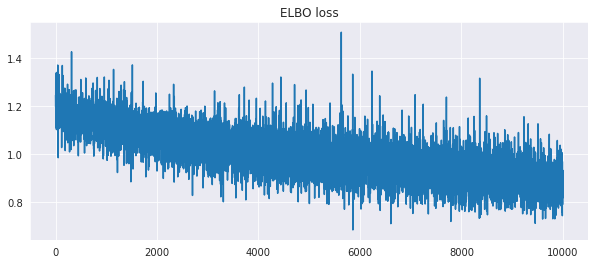

In [62]:
# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    w_setosa = pyro.sample("w_setosa", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_setosa = pyro.sample("b_setosa", dist.Normal(0.,1.))
    w_versi = pyro.sample("w_versi", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_versi = pyro.sample("b_versi", dist.Normal(0.,1.))
    w_virgi = pyro.sample("w_virgi", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b_virgi = pyro.sample("b_virgi", dist.Normal(0.,1.))
    
    # non-linearity
    yhat_setosa = torch.sigmoid((w_setosa*x).sum(dim=1) + b_setosa)
    yhat_versi = torch.sigmoid((w_versi*x).sum(dim=1) + b_versi)
    yhat_virgi = torch.sigmoid((w_virgi*x).sum(dim=1) + b_virgi)
    
    yhat = torch.stack([yhat_setosa, yhat_versi, yhat_virgi], dim=1)
    
    with pyro.plate("data", n_observations):
        y = pyro.sample("y", dist.Categorical(probs=yhat), obs=y)
        
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_setosa_loc = pyro.param("w_setosa_loc", torch.rand(n_predictors))
    w_setosa_scale = pyro.param("w_setosa_scale", torch.rand(n_predictors))
    w_setosa = pyro.sample("w_setosa", dist.Normal(w_setosa_loc, w_setosa_scale))
    b_setosa_loc = pyro.param("b_setosa_loc", torch.rand(1))
    b_setosa_scale = pyro.param("b_setosa_scale", torch.rand(1))
    b_setosa = pyro.sample("b_setosa", dist.Normal(b_setosa_loc, b_setosa_scale))
    
    w_versi_loc = pyro.param("w_versi_loc", torch.rand(n_predictors))
    w_versi_scale = pyro.param("w_versi_scale", torch.rand(n_predictors)) 
    w_versi = pyro.sample("w_versi", dist.Normal(w_versi_loc, w_versi_scale))
    b_versi_loc = pyro.param("b_versi_loc", torch.rand(1))
    b_versi_scale = pyro.param("b_versi_scale", torch.rand(1))
    b_versi = pyro.sample("b_versi", dist.Normal(b_versi_loc, b_versi_scale))
    
    w_virgi_loc = pyro.param("w_virgi_loc", torch.rand(n_predictors))
    w_virgi_scale = pyro.param("w_virgi_scale", torch.rand(n_predictors))
    w_virgi = pyro.sample("w_virgi", dist.Normal(w_virgi_loc, w_virgi_scale))
    b_virgi_loc = pyro.param("b_virgi_loc", torch.rand(1))
    b_virgi_scale = pyro.param("b_virgi_scale", torch.rand(1))
    b_virgi = pyro.sample("b_virgi", dist.Normal(b_virgi_loc, b_virgi_scale))
    
    

    
log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

Once trained the model, in order to predict the response variable of given an observation $x^*$ I evaluate  $ P(y^* = c |\mathbf{x^*},\mathbf{w_c}) \space \forall c \in C $ and then I assign 

$$ \hat{y} ^* = max_c [P(y^* = c |\mathbf{x^*},\mathbf{w_c})] $$

In [63]:
w_setosa = pyro.get_param_store()["w_setosa_loc"]
b_setosa = pyro.get_param_store()["b_setosa_loc"]

w_versi = pyro.get_param_store()["w_versi_loc"]
b_versi = pyro.get_param_store()["b_versi_loc"]

w_virgi = pyro.get_param_store()["w_virgi_loc"]
b_virgi = pyro.get_param_store()["b_virgi_loc"]


def predict_class(x):
    out_setosa = torch.sigmoid((w_setosa * x).sum(dim=1) + b_setosa)
    out_versi = torch.sigmoid((w_versi * x).sum(dim=1) + b_versi)
    out_virgi = torch.sigmoid((w_virgi * x).sum(dim=1) + b_virgi)
    
    out = torch.stack([out_setosa, out_versi, out_virgi], dim=1)
    
    return (torch.argmax(out, dim=1))

In [64]:
correct_predictions = (predict_class(x_test) == y_test).sum().item()

print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 96.67%


In [65]:
def accuracy_class(x_test,y_test, species):
    a = (predict_class(x_test) == y_test)
    b = (y_test == species)
    c = torch.zeros(len(y_test))

    for i in range(30):
        c[i] = a[i] and b[i]
    
    return(len(c[c==True])/len(b[b==True]))

In [66]:
print(f"setosa accuracy = {accuracy_class(x_test,y_test, 0)*100:.2f}%")
print(f"versicolor accuracy = {accuracy_class(x_test,y_test, 1)*100:.2f}%")
print(f"virginica accuracy = {accuracy_class(x_test,y_test, 2)*100:.2f}%")

setosa accuracy = 100.00%
versicolor accuracy = 100.00%
virginica accuracy = 90.00%
